## Calculate the volume of the shelf and the surface of the shelf bottom

In [27]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

from math import *

%matplotlib inline

from netCDF4 import Dataset

import seaborn as sns

import canyon_tools.readout_tools as rdout

import canyon_tools.metrics_tools as mpt


In [15]:
# load grid variables
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
GridOut = Dataset(Grid)
GridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
GridNoCOut = Dataset(GridNoC)

State03 =  '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
StateOut =   Dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc')

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rdout.getField(Grid, 'XC') # x coords tracer cells
yc = rdout.getField(Grid, 'YC') # y coords tracer cells
rc = GridOut.variables['RC']
z = StateOut.variables['Z']

bathy = rdout.getField(Grid, 'Depth')
hFacC = rdout.getField(Grid, 'HFacC')
MaskC = rdout.getMask(Grid, 'HFacC')

rA = rdout.getField(Grid, 'rA') 
drF = GridOut.variables['drF'] # vertical distance between faces
drC = GridOut.variables['drC'] # vertical distance between centers
dxf = GridOut.variables['dxF']

hFacCNoC = rdout.getField(GridNoC, 'HFacC')
mask_NoC = rdout.getMask(GridNoC, 'HFacC')
rANoC = rdout.getField(GridNoC, 'rA') 
bathyNoC = rdout.getField(GridNoC, 'Depth')



In [18]:
def calc_volume_shelf(MaskC,rA,hFacC,drF,yin=227,zfin=30):
    ''' INPUT----------------------------------------------------------------------------------------------------------------
    MaskC : Land mask for tracer, canyon case
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360) canyon case
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    Volume: Volume of the cells of the shelf box (90-zin,360-yin,360)
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = MaskC
    
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    
    
    return (ShelfVolume)

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def SBArea(hfac, ra, bathy, sbdepth=-152.5):
    '''hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       masked(Area) = Area of shelf bottom with canyon masked out.'''
    
    
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                
                Area[i,j] = ra[i,j]
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    
    return (np.ma.masked_array(Area, mask=maskShelf))

## Volume of shelf box 

In [13]:
Volume_cells = calc_volume_shelf(MaskC,rA,hFacC,drF)

In [43]:
total_Vol = np.sum(Volume_cells)
print('The total volume of the shelf box is %e $m^3$' %total_Vol)

The total volume of the shelf box is 2.555600e+11 $m^3$


## Area of shelf bottom and canyon lid

In [19]:
area_shelf = SBArea(hFacC, rA, bathy, sbdepth=-152.5)
area_shelf_NoC = SBArea(hFacCNoC, rANoC, bathyNoC, sbdepth=-152.5)

(360, 360)
(360, 360)


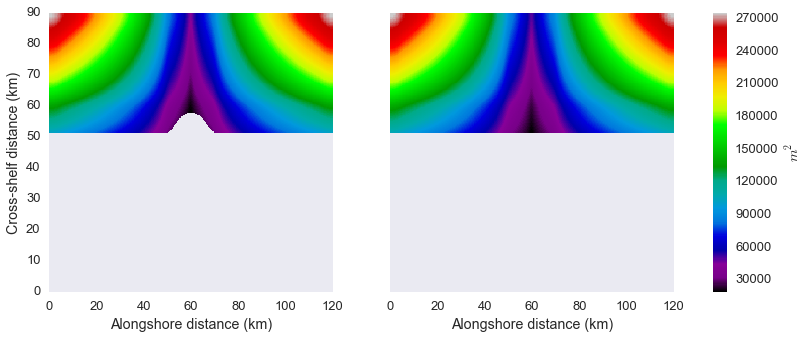

In [38]:
sns.set_context('talk')
fig,ax = plt.subplots(1,2, figsize = (14,5), sharey = True)

pc1 = ax[0].pcolor(xc/1000.0,yc/1000.0,area_shelf,cmap = 'spectral')
pc2 = ax[1].pcolor(xc/1000.0,yc/1000.0,area_shelf_NoC,cmap='spectral')

cax,kw = mpl.colorbar.make_axes([ax[0],ax[1]],location='right',shrink=1, pad = 0.05)
cb = plt.colorbar(pc2, cax=cax,**kw)
cb.set_label('$m^2$')

ax[0].set_ylabel('Cross-shelf distance (km)')
ax[0].set_xlabel('Alongshore distance (km)')
ax[1].set_xlabel('Alongshore distance (km)')

In [55]:
area_Can_bottom = np.nansum(area_shelf)
area_NoC_bottom = np.nansum(area_shelf_NoC)
area_canyon = area_NoC_bottom - area_Can_bottom

print('Shelf bottom area without canyon: %e m^2' %area_NoC_bottom)
print('Shelf bottom area with canyon: %e m^2' %area_Can_bottom)
print('Canyon lid area: %e m^2' %area_canyon)

print('The canyon represents %f percent of the flat shelf area' %(100.0*area_canyon/area_NoC_bottom))
print('The canyon represents %f percent of the canyon shelf area' %(100.0*area_canyon/area_Can_bottom))

Shelf bottom area without canyon: 4.650000e+09 m^2
Shelf bottom area with canyon: 4.567880e+09 m^2
Canyon lid area: 8.212013e+07 m^2
The canyon represents 1.766024 percent of the flat shelf area
The canyon represents 1.797773 percent of the canyon shelf area


In [57]:
print('Shelf volume is %f times larger than the volume of the active part of the canyon (400m-150m)' 
      %(total_Vol/(area_canyon*250.0/3)))

print('Canyon volume represents %f percent of shelf volume' %((100.0*(area_canyon*250.0/3))/total_Vol))

Shelf volume is 37.344323 times larger than the volume of the active part of the canyon (400m-150m)
Canyon volume represents 2.677783 percent of shelf volume


In [58]:
area_canyon*250.0/3

6843343988.8207903